In [1]:
import pandas as pd
import os
import sys
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, results_path
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report
)


# # Load the saved predictions
# file_name = 'results_ResNet_all_runs.csv'

# path = os.path.join(results_path, file_name)
# df = pd.read_csv(path)
df = pd.read_csv('results_ResNet_all_runs.csv')

def extract_base_record_id(window_id):
    return re.sub(r"-chan\d+-\d+$", "", window_id)
    df["base_record_id"] = df["window_id"].apply(extract_base_record_id)



Run 1 — Confusion Matrix:
[[ 14  54]
 [144 108]]
              precision    recall  f1-score   support

           0     0.0886    0.2059    0.1239        68
           1     0.6667    0.4286    0.5217       252

    accuracy                         0.3812       320
   macro avg     0.3776    0.3172    0.3228       320
weighted avg     0.5438    0.3812    0.4372       320


📊 Aggregated Soft Voting Over Channels (Per Window) — 1 Runs:

Accuracy  : 0.3812 ± nan
Precision : 0.6667 ± nan
Recall    : 0.4286 ± nan
F1        : 0.5217 ± nan
Auc       : 0.2432 ± nan
Ap        : 0.6984 ± nan

🧩 Confusion Matrix (Final Soft Voting Over Channels):
[[ 14  54]
 [144 108]]

📃 Classification Report (Final Soft Voting Over Channels):
              precision    recall  f1-score   support

           0     0.0886    0.2059    0.1239        68
           1     0.6667    0.4286    0.5217       252

    accuracy                         0.3812       320
   macro avg     0.3776    0.3172    0.3228       320

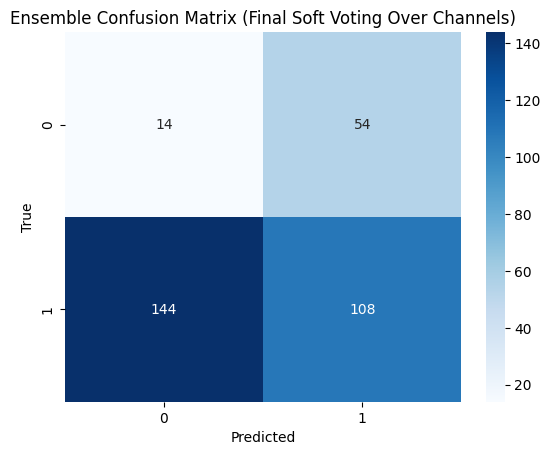

In [9]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Extract base_window_id (strip channel only)
df["base_window_id"] = df["window_id"].apply(lambda x: re.sub(r"-chan\d+", "", x))

# Identify run indices (assuming columns like 'pred_prob0', 'pred_prob1', ...)
run_indices = sorted(set(int(col.replace("pred_label", "")) for col in df.columns if col.startswith("pred_label")))

metrics_list = []
aggregated_probs_per_run = []

for i in run_indices:
    prob_col = f"pred_prob{i}"

    # ✅ Aggregate over channels (per base_window_id) via mean of probabilities
    aggregated = df.groupby("base_window_id").agg({
        prob_col: "mean",                      # soft vote over channels
        "target": lambda x: x.iloc[0]          # target is the same for all channels of the window
    }).reset_index()

    # Store for final aggregation
    aggregated_probs_per_run.append(aggregated.set_index("base_window_id")[prob_col])

    # Threshold to get predicted labels
    aggregated[f"pred_label{i}"] = (aggregated[prob_col] >= 0.5).astype(int)

    # Evaluate this run
    y_true = aggregated["target"].values
    y_pred = aggregated[f"pred_label{i}"].values
    y_prob = aggregated[prob_col].values

    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan
    try:
        ap = average_precision_score(y_true, y_prob)
    except ValueError:
        ap = np.nan

    metrics_list.append({
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": auc,
        "ap": ap
    })
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nRun {i} — Confusion Matrix:")
    print(cm)
    print(classification_report(y_true, y_pred, digits=4))


# 📊 Metrics summary
metrics_df = pd.DataFrame(metrics_list)
mean_metrics = metrics_df.mean()
std_metrics = metrics_df.std()

print(f"\n📊 Aggregated Soft Voting Over Channels (Per Window) — {len(run_indices)} Runs:\n")
for metric in mean_metrics.index:
    print(f"{metric.capitalize():<10}: {mean_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")

# 🧮 Final soft voting across runs (mean of probs)
mean_probs = pd.concat(aggregated_probs_per_run, axis=1).mean(axis=1)
final_targets = df.groupby("base_window_id")["target"].first()

final_df = pd.DataFrame({
    "pred_prob": mean_probs,
    "target": final_targets
})
final_df["pred_label"] = (final_df["pred_prob"] >= 0.5).astype(int)

# 🧩 Final Confusion Matrix
y_true = final_df["target"].values
y_pred = final_df["pred_label"].values

cm = confusion_matrix(y_true, y_pred)
print("\n🧩 Confusion Matrix (Final Soft Voting Over Channels):")
print(cm)
print("\n📃 Classification Report (Final Soft Voting Over Channels):")
print(classification_report(y_true, y_pred, digits=4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix (Final Soft Voting Over Channels)')
plt.show()


 1. Channel-wise Accuracy (Majority Voting Per Channel)
Evaluate each channel's predictions independently by aggregating over all windows that belong to that channel, then compare with ground truth.


📈 Channel-wise Accuracy Across Runs:
   channel      mean  std
5        5  0.381250  NaN
0        0  0.365625  NaN
1        1  0.362500  NaN
4        4  0.356250  NaN
2        2  0.353125  NaN
3        3  0.346875  NaN


/scratch-local/nwertheim.11967210/ipykernel_1500268/1299613592.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_summary, x="channel", y="mean", palette="viridis", capsize=0.2)


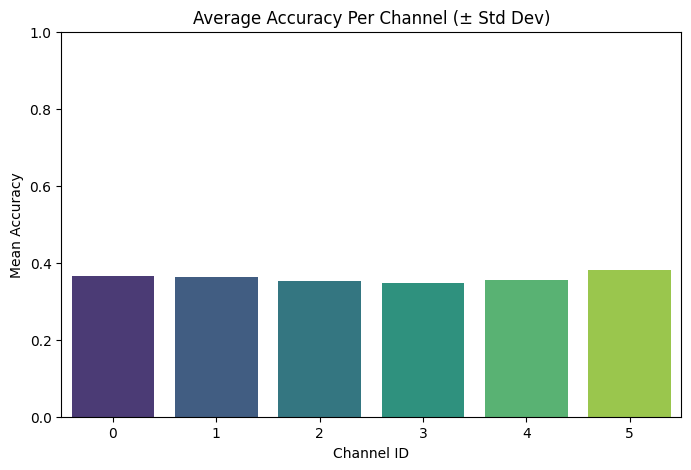

In [4]:
# Extract channel number from window_id
df["channel_id"] = df["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)))

channel_stats = []

for chan in sorted(df["channel_id"].unique()):
    chan_df = df[df["channel_id"] == chan]
    
    for i in run_indices:
        prob_col = f"pred_prob{i}"
        label_col = f"pred_label{i}"

        chan_run_df = chan_df.copy()
        chan_run_df["base_record_id"] = chan_run_df["window_id"].apply(lambda x: re.sub(r"-chan\d+-\d+$", "", x))
        
        # Aggregate by window
        agg = chan_run_df.groupby("window_id").agg({
            prob_col: "mean",
            "target": lambda x: x.iloc[0]
        }).reset_index()
        
        agg[f"pred_label"] = (agg[prob_col] >= 0.5).astype(int)
        
        acc = accuracy_score(agg["target"], agg["pred_label"])
        
        channel_stats.append({
            "channel": chan,
            "run": i,
            "accuracy": acc
        })

channel_stats_df = pd.DataFrame(channel_stats)

# 📊 Summarize accuracy per channel
channel_summary = channel_stats_df.groupby("channel")["accuracy"].agg(["mean", "std"]).reset_index()
channel_summary = channel_summary.sort_values("mean", ascending=False)

print("\n📈 Channel-wise Accuracy Across Runs:")
print(channel_summary)

import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=channel_summary, x="channel", y="mean", palette="viridis", capsize=0.2)
plt.title("Average Accuracy Per Channel (± Std Dev)")
plt.ylabel("Mean Accuracy")
plt.xlabel("Channel ID")
plt.ylim(0, 1)
plt.show()


2. Channel Contribution to Correct Prediction (Voting Consistency)
For each window (across all channels), compute how often each channel votes the correct label (agreeing with the ground truth), and use this to get a sense of reliability:

In [5]:
# Add column with correct predictions per channel per run
correct_per_channel = []

for i in run_indices:
    label_col = f"pred_label{i}"
    
    temp = df.copy()
    temp["channel_id"] = temp["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)))
    temp["correct"] = (temp[label_col] == temp["target"]).astype(int)
    
    stats = temp.groupby("channel_id")["correct"].mean().reset_index()
    stats["run"] = i
    correct_per_channel.append(stats)

correct_df = pd.concat(correct_per_channel)

# Summarize
correct_summary = correct_df.groupby("channel_id")["correct"].agg(["mean", "std"]).reset_index()
correct_summary = correct_summary.sort_values("mean", ascending=False)

print("\n✅ Correctness Rate Per Channel (Average over runs):")
print(correct_summary)



✅ Correctness Rate Per Channel (Average over runs):
   channel_id      mean  std
5           5  0.381250  NaN
0           0  0.365625  NaN
1           1  0.362500  NaN
4           4  0.356250  NaN
2           2  0.353125  NaN
3           3  0.346875  NaN


3. Channel Disagreement Analysis
Count how often each channel disagrees with the final soft-voted window label, which can show which channels are less aligned with the consensus.

In [6]:
# Assume final prediction per window is already computed (you can reuse your soft-voting logic)
# Here we'll assume you soft-voted over channels per window and got: final_window_preds_df
# It should have: window_id, final_pred_label, target

# Merge back channel-specific predictions
disagreement_stats = []

for i in run_indices:
    label_col = f"pred_label{i}"
    temp = df[["window_id", "target", label_col]].copy()
    temp = temp.rename(columns={label_col: "channel_pred"})
    temp["channel_id"] = temp["window_id"].apply(lambda x: int(re.search(r"chan(\d+)", x).group(1)))

    # You should already have a DataFrame with final per-window predictions (after soft voting over channels)
    # For simplicity, recompute it quickly:
    final_pred_per_window = df.groupby("window_id")[f"pred_prob{i}"].mean().reset_index()
    final_pred_per_window["final_pred"] = (final_pred_per_window[f"pred_prob{i}"] >= 0.5).astype(int)

    merged = pd.merge(temp, final_pred_per_window[["window_id", "final_pred"]], on="window_id")

    merged["disagrees_with_final"] = (merged["channel_pred"] != merged["final_pred"]).astype(int)

    stat = merged.groupby("channel_id")["disagrees_with_final"].mean().reset_index()
    stat["run"] = i
    disagreement_stats.append(stat)

disagreement_df = pd.concat(disagreement_stats)

# Summarize
disagreement_summary = disagreement_df.groupby("channel_id")["disagrees_with_final"].agg(["mean", "std"]).reset_index()
disagreement_summary = disagreement_summary.sort_values("mean")

print("\n🤔 Channel Disagreement Rate with Final Prediction:")
print(disagreement_summary)



🤔 Channel Disagreement Rate with Final Prediction:
   channel_id  mean  std
0           0   0.0  NaN
1           1   0.0  NaN
2           2   0.0  NaN
3           3   0.0  NaN
4           4   0.0  NaN
5           5   0.0  NaN
